Ambystoma barbouri state range summary


,FWS_range(y/n),BISON_data(y/n),SGCN_2005(y/n),SGCN_2015(y/n),GAP_habitat(y/n),habitat_(%),habitat_1&2(%),habitat_3(%)
State,,,,,,,,
Alabama,1,1,0,0,0,0,0,0
Arizona,0,1,0,0,0,0,0,0
Arkansas,0,1,0,0,0,0,0,0
California,0,1,0,0,0,0,0,0
Colorado,0,1,0,0,0,0,0,0
Connecticut,0,1,0,0,0,0,0,0
Florida,0,1,0,0,0,0,0,0
Georgia,0,1,0,0,0,0,0,0
Idaho,0,1,0,0,0,0,0,0


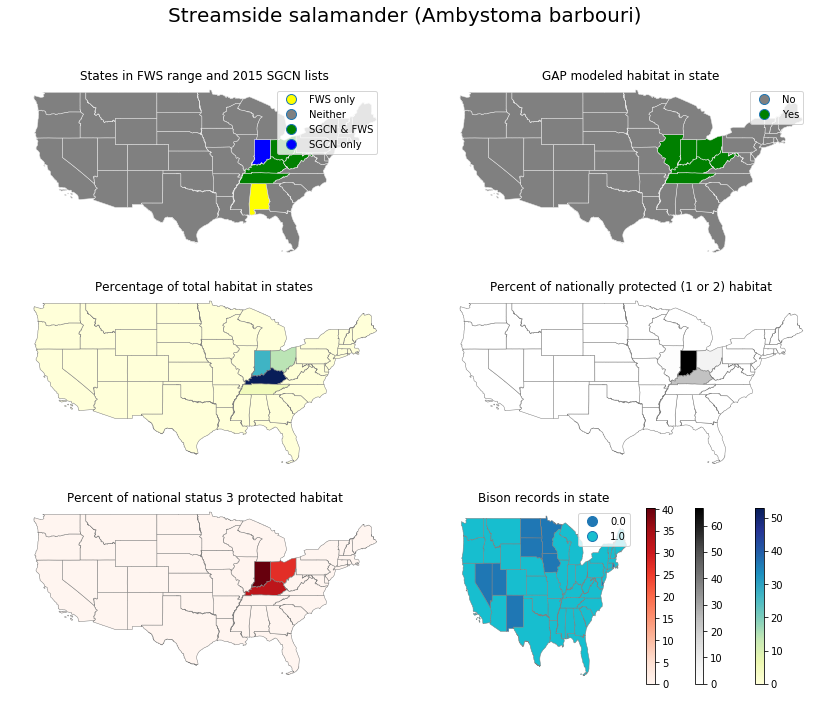

In [6]:
%matplotlib inline  


# -*- coding: utf-8 -*-
"""
nmtarr 9/7/2018

Description: Script used in developing State range summaries.ipynb.

"""
#from IPython.display import display as display1
from matplotlib.colors import ListedColormap    
import us
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 12)
pd.set_option('display.max_rows', 100)
# Widens the display in a notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# import config file with username and password
import sys
sys.path.append("T:/BCB/")
import BISdbConfig as config

# pybis needs environment variables to connect to the database.
import os
os.environ['DB_USERNAME']=config.user
os.environ['DB_PASSWORD']=config.password
os.environ['MONGODB_SERVER']="54.91.95.139"
os.environ['DB_DATABASE']="bis"

# Read in state geojson up front since it takes a few seconds
statesGDF0 = gpd.read_file("T:/Data/state_boundaries.geojson") 

# Connect to bis and get collection and species list to loop on
from pybis import db
bisDB = db.Db.connect_mongodb("bis")
esaWPSpecies = bisDB["FWS_Work_Plan_Species"]

# Get a list of species names to loop on.
spp = [record["Submitted Data"]["Scientific Name"] for record in esaWPSpecies.find()]
for sp in spp[:1]:
    common = esaWPSpecies.find_one({"Submitted Data.Scientific Name": sp})['Submitted Data']['Common Name']
    ############################################# Build empty dataframe to fill out
    columns=[]
    df0 = pd.DataFrame(index=[str(x) for x in us.STATES], columns=columns)
    df0.index.name="State"
    df0.name=sp
    
    ##########################################################################  FWS
    # Fill out ECOS column with whether or not the ECOS account lists the state
    try:
        Synth = esaWPSpecies.find_one({"Submitted Data.Scientific Name": sp})['Synthesis']
        FWS_states = Synth['FWS Range List']
        for x in FWS_states:
            state_name = x.strip()
            df0.loc[state_name, 'FWS_range(y/n)'] = 1
    except:
        print("Exception -- FWS range")
    # Which states have bison occurrences?
    try:
        BISON_states = Synth['States with BISON Occurrence Data']
        for x in BISON_states:
            state_name = x.strip()
            df0.loc[state_name, 'BISON_data(y/n)'] = 1
    except:
        print("Exception -- BISON state list")
    
    ###############################################################################    
    ###############################################################  Fill out table
    ###############################################################################
    # Which states declared it SGCN?
    try:
        for x in Synth['SGCN State List 2005']:
            df0.loc[x, 'SGCN_2005(y/n)'] = 1
    
    except:
        print("Exception -- SGCN 2005") 
        
    try:
        for x in Synth['SGCN State List 2015']:
            df0.loc[x, 'SGCN_2015(y/n)'] = 1    
    except:
        print('Exception -- SGCN 2015')
 
    # Which states have potential habitat (GAP)?
    try:
        GAP_states = Synth['States with GAP Species Potential Habitat']
        for x in GAP_states:
            state_name = x.strip()
            df0.loc[state_name, 'GAP_habitat(y/n)'] = 1
    except:
        print('Exception -- GAP states, species')
        
        
        
    # Proportion of habitat in state?
    try:
        GAPmet = esaWPSpecies.find_one({"Submitted Data.Scientific Name": sp})['GAP']
        CONUS = [t for t in GAPmet['State Metrics'] if t['state_name']=='CONUS'][0]
        CONUS_ac = CONUS['totalac']
        for dd in GAPmet['State Metrics']:
            state_ac = dd['totalac']
            df0.loc[dd['state_name'], 'habitat_(%)'] = 100.*(state_ac/CONUS_ac)
    except:
        print('Exception -- GAP proportion habitat')
        

        
    # What is proportion of protected (1&2) GAP habitat in each state
    try:
        # Get CONUS totals for species
        CONUS_12 = CONUS['gapstat12ac']
        for j in GAPmet['State Metrics']:
            state_12 = j['gapstat12ac']
            df0.loc[j['state_name'], ' habitat_1&2(%)'] = 100.*(state_12/CONUS_12)
    except:
        print('Exception -- GAP habitat 1 and 2')
    
    # What is proportion of protected (3) GAP habitat in each state
    try:
        # Get CONUS totals for species
        CONUS_3 = CONUS['gapstat3ac']
        for j in GAPmet['State Metrics']:
            state_3 = j['gapstat3ac']
            df0.loc[j['state_name'], ' habitat_3(%)'] = 100.*(state_3/CONUS_3)
    except:
        print('Exception -- GAP habitat 1 and 2')
    
    ################################################### Clean up table
    df1 = df0.fillna(0)
    # get rid of non-CONUS states
    lowers = [str(x) for x in us.STATES_CONTINENTAL]
    lowers.remove('Alaska')
    print(sp + ' state range summary')
    df2 = df1.filter(items=lowers, axis=0)
    # drop rows with all zeros
    df3 = df2.loc[(df2!=0).any(axis=1)].astype(int)
    display(df3)
    print('\n\n')
    
    ########################################  Add comparison fields
    # Compare SGCN 2015 to FWS, handle possible absence of columns
    if 'SGCN_2015(y/n)' in df2.columns and 'FWS_range(y/n)' in df2.columns:
        df2['SGCN2015-FWS'] = list(zip(df2['SGCN_2015(y/n)'], df2['FWS_range(y/n)']))
    if 'SGCN_2015(y/n)' not in df2.columns and 'FWS_range(y/n)' in df2.columns:
        df2['SGCN2015-FWS'] = [(0, df2.loc[x, 'FWS_range(y/n)']) for x in df2.index]
    if 'SGCN_2015(y/n)' in df2.columns and 'FWS_range(y/n)' not in df2.columns:
        df2['SGCN2015-FWS'] = [(df2.loc[x, 'SGCN_2015(y/n)'], 0) for x in df2.index]
    codeDict = {(1,1): 'SGCN & FWS', (1,0): 'SGCN only', 
                (0,1): 'FWS only', (0,0): 'Neither'}
    df2['SGCN2015-FWS'] = [codeDict[x] for x in df2['SGCN2015-FWS']]


    ###############################################################################
    ####################################################################  Plot maps
    ###############################################################################       
    # Join states geodataframe with species dataframe
    statesGDF = statesGDF0.copy()
    statesGDF2 = pd.merge(df2, statesGDF, how='inner', 
                          left_on=df2.index, right_on=statesGDF.STATE_NAME)
    statesGDF3 = gpd.GeoDataFrame(statesGDF2)
    statesGDF3 = statesGDF3[statesGDF3.STATE_NAME != 'Alaska']
    
    # Style settings
    titleSize = 20
    labelSize = 14
    figsizeCat = (7,3)
    figsizeCon = (7,3)
    
    # Create a figure to plot on
    fig, axes = plt.subplots(3,2, figsize = (14,11))
    fig.suptitle("{0} ({1})".format(common.capitalize(), sp), fontsize=titleSize)
        
    ######################################################### SGCN 2015 vs. FWS
    ax = axes[0,0]
    statesGDF3.plot(ax=ax, column="SGCN2015-FWS", legend=True, 
                    cmap=ListedColormap(['yellow', 'grey', 'green', 'blue']),
                    categorical=True, linewidth=0.5, edgecolor='0.9',
                    figsize=figsizeCat)
    ax.set_ylim(23, 50)
    ax.set_xlim(-126, -66)
    ax.set_axis_off()
    ax.set_title('States in FWS range and 2015 SGCN lists')
    
    ############################################################### GAP Habitat
    # Presence of GAP habitat
    ax = axes[0,1]
    if 'GAP_habitat(y/n)' in statesGDF3.columns:
        statesGDF3['GAP_habitat(y/n)'] = [{0: "No", 
                   1: "Yes"}[x] for x in statesGDF3['GAP_habitat(y/n)']]
        # Plot
        statesGDF3.plot(ax=ax, column="GAP_habitat(y/n)", legend=True, 
                        cmap=ListedColormap(['grey', 'green']),
                        categorical=True, linewidth=0.5, edgecolor='0.9', 
                        figsize=figsizeCat)
        ax.set_ylim(23, 50)
        ax.set_xlim(-126, -66)
        ax.set_axis_off()
        ax.set_title('GAP modeled habitat in state')
    
    # Proportion of habitat
    ax = axes[1,0]
    if 'habitat_(%)' in statesGDF3.columns:
        # Plot
        statesGDF3.plot(ax=ax, column="habitat_(%)", legend=True, 
                        categorical=False, linewidth=0.5, edgecolor='0.5', 
                        figsize=figsizeCon, cmap='YlGnBu')
        ax.set_ylim(23, 50)
        ax.set_xlim(-126, -66)
        ax.set_axis_off()
        ax.set_title('Percentage of total habitat in states')
    
    ############################################################ GAP Protection
    ax = axes[1,1]
    if ' habitat_1&2(%)' in statesGDF3.columns:
        # Plot
        statesGDF3.plot(ax=ax, column=" habitat_1&2(%)", 
                        categorical=False, linewidth=0.5, edgecolor='.5', 
                        figsize=figsizeCon, cmap='Greys', legend=True)
        ax.set_ylim(23, 50)
        ax.set_xlim(-126, -66)
        ax.set_axis_off()
        ax.set_title('Percent of nationally protected (1 or 2) habitat')
    
    ax = axes[2,0]
    if ' habitat_3(%)' in statesGDF3.columns:
        # Plot
        statesGDF3.plot(ax=ax, column=" habitat_3(%)", 
                        categorical=False, linewidth=0.5, edgecolor='.5', 
                        figsize=figsizeCon, cmap='Reds', legend=True)
        ax.set_ylim(23, 50)
        ax.set_xlim(-126, -66)
        ax.set_axis_off()
        ax.set_title('Percent of national status 3 protected habitat')
        
    ax = axes[2,1]
    if 'BISON_data(y/n)' in statesGDF3.columns:
        # Plot
        statesGDF3.plot(ax=ax, column="BISON_data(y/n)", 
                        categorical=True, linewidth=0.5, edgecolor='.5', 
                        figsize=figsizeCat, legend=True)
        ax.set_axis_off()
        ax.set_title('Bison records in state')
    plt.show()